Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Letter Recognition Image Classifcation Model 

## Setup

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.28.0


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

amipatel-ws	westus	pipelinesusabilitystudy


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'Tutorial-sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource

**Creation of compute takes approximately 5 minutes.** 

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target: cpu-cluster



## Explore data

### Download the our sample dataset


In [5]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

Create an experiment named "tf-mnist" and a folder to hold training scripts

In [6]:
from azureml.core import Experiment

script_folder = './tf-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='tf-mnist')

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

In [9]:
pwd

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/sandbox/code'

In [8]:
# make sure utils.py is in the same directory as this code
from utils import load_data
import glob


# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder,"**/train-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)


# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

ModuleNotFoundError: No module named 'utils'

## Train on a remote cluster

For this task, you submit the job to run on the remote training cluster you set up earlier.  To submit a job you:
* Create a directory
* Create a training script
* Create a script run configuration
* Submit the job 

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.

In [ ]:
import os
script_folder = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called `train.py` in the directory you just created. 

In [ ]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/sandbox/code/Users/amipatel/image-classification-mnist-data/sklearn-mnist/train.py


Notice how the script gets data and saves models:

+ The training script reads an argument to find the directory containing the data.  When you submit the job later, you point to the dataset for this argument:
`parser.add_argument('--data-folder', type=str, dest='data_folder', help='data directory mounting point')`


+ The training script saves your model into a directory named outputs. <br/>
`joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')`<br/>
Anything written in this directory is automatically uploaded into your workspace. You'll access your model from this directory later in the tutorial.

The file `utils.py` is referenced from the training script to load the dataset correctly.  Copy this script into the script folder so that it can be accessed along with the training script on the remote resource.

In [ ]:
import shutil
shutil.copy('utils.py', script_folder)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/sandbox/code/Users/amipatel/image-classification-mnist-data/sklearn-mnist/utils.py'

In [ ]:
shutil.copy('./tf_mnist.py', script_folder)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/sandbox/code/Users/amipatel/image-classification-mnist-data/sklearn-mnist/tf_mnist.py'

In [ ]:
from azureml.core import Environment
tf_env = Environment.get(ws, name='AzureML-TensorFlow-2.0-CPU')


from azureml.core import ScriptRunConfig

args = ['--data-folder', mnist_file_dataset.as_named_input('mnist').as_mount(),
        '--batch-size', 64,
        '--first-layer-neurons', 256,
        '--second-layer-neurons', 128,
        '--learning-rate', 0.01]

src = ScriptRunConfig(source_directory=script_folder,
                      script='tf_mnist.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=tf_env)

## Integrate Tensorboard

In [ ]:
from azureml.core import Workspace, Experiment
import azureml.core

# set experiment name and run name
ws = Workspace.from_config()
experiment_name = 'export-to-tensorboard'
exp = Experiment(ws, experiment_name)
root_run = exp.start_logging()

In [ ]:
from azureml.tensorboard.export import export_to_tensorboard
import os

logdir = 'exportedTBlogs'
log_path = os.path.join(os.getcwd(), logdir)
try:
    os.stat(log_path)
except os.error:
    os.mkdir(log_path)
print(logdir)

# export run history for the project
export_to_tensorboard(root_run, logdir)

root_run.complete()

exportedTBlogs


### Submit the job to the cluster

Run the experiment by submitting the ScriptRunConfig object. And you can navigate to Azure portal to monitor the run.

In [ ]:
run = exp.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
export-to-tensorboard,export-to-tensorboard_1626729527_a8b45555,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


Since the call is asynchronous, it returns a **Preparing** or **Running** state as soon as the job is started.

## Monitor a remote run

In total, the first run takes **approximately 10 minutes**. But for subsequent runs, as long as the dependencies in the Azure ML environment don't change, the same image is reused and hence the container start up time is much faster.

Here is what's happening while you wait:

- **Image creation**: A Docker image is created matching the Python environment specified by the Azure ML environment. The image is built and stored in the ACR (Azure Container Registry) associated with your workspace. Image creation and uploading takes **about 5 minutes**. 

  This stage happens once for each Python environment since the container is cached for subsequent runs.  During image creation, logs are streamed to the run history. You can monitor the image creation progress using these logs.

- **Scaling**: If the remote cluster requires more nodes to execute the run than currently available, additional nodes are added automatically. Scaling typically takes **about 5 minutes.**

- **Running**: In this stage, the necessary scripts and files are sent to the compute target, then data stores are mounted/copied, then the entry_script is run. While the job is running, stdout and the files in the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs.

- **Post-Processing**: The ./outputs directory of the run is copied over to the run history in your workspace so you can access these results.


You can check the progress of a running job in multiple ways. This tutorial uses a Jupyter widget as well as a `wait_for_completion` method. 

### Jupyter widget

Watch the progress of the run with a Jupyter widget.  Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

By the way, if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

### Get log results upon completion

Model training happens in the background. You can use `wait_for_completion` to block and wait until the model has completed training before running more code. 

In [ ]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True) 

RunId: export-to-tensorboard_1626729527_a8b45555
Web View: https://ml.azure.com/runs/export-to-tensorboard_1626729527_a8b45555?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/pipelinesusabilitystudy/workspaces/amipatel-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47

Streaming azureml-logs/55_azureml-execution-tvmps_659016bb9e0b5976706462991414eeba3a3fbe20edc298cc8bda59c611a0850b_d.txt

2021-07-19T21:21:57Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/amipatel-ws/azureml/export-to-tensorboard_1626729527_a8b45555/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/amipatel-ws/azureml/export-to-tensorboard_1626729527_a8b45555/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=24788 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/amipatel-ws/azureml/export-to-tensorboard_1626729527_a8b45555/configs/workspaceblobstore.cfg --log-level=LOG

{'runId': 'export-to-tensorboard_1626729527_a8b45555',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-07-19T21:21:59.598514Z',
 'endTimeUtc': '2021-07-19T21:24:59.639645Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '2d4c6f5f-41cd-4fd4-8bb1-4f585df7958a',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json',
  'azureml.RuntimeType': '',
  'azureml.datastoreId': '/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/pipelinesusabilitystudy/providers/Microsoft.MachineLearningServices/workspaces/amipatel-ws/datastores/amipatelws1636025664_azureml'},
 'inputDatasets': [{'dataset': {'id': 'f52aaa18-a2cf-4eec-847c-00ceb183a4de'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'mnist', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'tf_mnist.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-fol

### Launch Tensorboard

In [ ]:
from azureml.tensorboard import Tensorboard

# The TensorBoard constructor takes an array of runs, so be sure and pass it in as a single-element array here
tb = Tensorboard([], local_root=logdir, port=6006)

# If successful, start() returns a string with the URI of the instance.
tb.start()

https://sandbox-6006.westus.instances.azureml.ms


'https://sandbox-6006.westus.instances.azureml.ms'

### Display run results

You now have a model trained on a remote cluster.  Retrieve all the metrics logged during the run, including the accuracy of the model:

In [ ]:
print(run.get_metrics())

{'training_acc': [0.84375, 0.921875, 0.9375, 0.9375, 0.9375, 0.953125, 0.9375, 0.984375, 0.984375, 0.9375, 0.953125, 0.984375, 0.984375, 0.9375, 0.90625, 0.9375, 0.984375, 1.0, 0.984375, 0.984375], 'validation_acc': [0.895799994468689, 0.9154999852180481, 0.926800012588501, 0.9326000213623047, 0.9390000104904175, 0.942300021648407, 0.9462000131607056, 0.948199987411499, 0.95169997215271, 0.9521999955177307, 0.9544000029563904, 0.9571999907493591, 0.9596999883651733, 0.9609000086784363, 0.9625999927520752, 0.964900016784668, 0.9646999835968018, 0.9667999744415283, 0.9666000008583069, 0.9677000045776367], 'final_acc': 0.9677000045776367}


In the next tutorial you will explore this model in more detail.

## Register model

The last step in the training script wrote the file `outputs/sklearn_mnist_model.pkl` in a directory named `outputs` in the VM of the cluster where the job is executed. `outputs` is a special directory in that all content in this  directory is automatically uploaded to your workspace.  This content appears in the run record in the experiment under your workspace. Hence, the model file is now also available in your workspace.

You can see files associated with that run.

In [ ]:
print(run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_659016bb9e0b5976706462991414eeba3a3fbe20edc298cc8bda59c611a0850b_d.txt', 'azureml-logs/65_job_prep-tvmps_659016bb9e0b5976706462991414eeba3a3fbe20edc298cc8bda59c611a0850b_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_659016bb9e0b5976706462991414eeba3a3fbe20edc298cc8bda59c611a0850b_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/75_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'logs/azureml/sidecar/tvmps_659016bb9e0b5976706462991414eeba3a3fbe20edc298cc8bda59c611a0850b_d/all.log', 'logs/azureml/sidecar/tvmps_659016bb9e0b5976706462991414eeba3a3fbe20edc298cc8bda59c611a0850b_d/task.enter_contexts.log', 'logs/azureml/sidecar/tvmps_659016bb9e0b5976706462991414eeba3a3fbe20edc298cc8bda59c611a0850b_d/task.exit_contexts.log', 'outputs/-1.d

## Plot accuracy over epochs
Since we can retrieve the metrics from the run, we can easily make plots using matplotlib in the notebook. Then we can add the plotted image to the run using run.log_image(), so all information about the run is kept together.

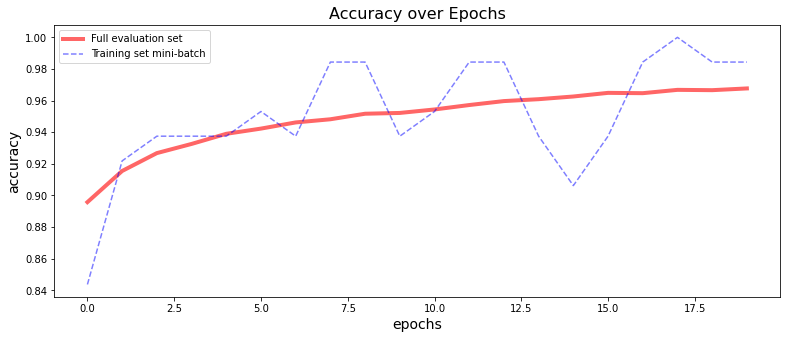

In [ ]:
os.makedirs('./imgs', exist_ok=True)
metrics = run.get_metrics()

plt.figure(figsize = (13,5))
plt.plot(metrics['validation_acc'], 'r-', lw=4, alpha=.6)
plt.plot(metrics['training_acc'], 'b--', alpha=0.5)
plt.legend(['Full evaluation set', 'Training set mini-batch'])
plt.xlabel('epochs', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('Accuracy over Epochs', fontsize=16)
run.log_image(name='acc_over_epochs.png', plot=plt)
plt.show()

## Download the saved model

In the training script, a TensorFlow saver object is used to persist the model in a local folder (local to the compute target). The model was saved to the ./outputs folder on the disk of the Batch AI cluster node where the job is run. Azure ML automatically uploaded anything written in the ./outputs folder into run history file store. Subsequently, we can use the Run object to download the model files the saver object saved. They are under the the outputs/model folder in the run history file store, and are downloaded into a local folder named model. Note the TensorFlow model consists of four files in binary format and they are not human-readable.

In [ ]:
run.download_files(prefix='outputs/model', output_directory='./model', append_prefix=False)

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/img-classification-part1-training.png)